In [1]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import librosa
import math

from scipy.ndimage import generate_binary_structure
from scipy.ndimage import iterate_structure

from typing import Tuple, List

from numba import njit

In [2]:
# https://github.com/Sarcovora/CogWorks-2022-Gausslien-Audio-Capstone/blob/main/CogZam/peakExtraction.py

@njit
def _peaks(
    data_2d: np.ndarray, nbrhd_row_offsets: np.ndarray, nbrhd_col_offsets: np.ndarray, amp_min: float
) -> List[Tuple[int, int]]:
    """
    A Numba-optimized 2-D peak-finding algorithm.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected.

    nbrhd_row_offsets : numpy.ndarray, shape-(N,)
        The row-index offsets used to traverse the local neighborhood.
        
        E.g., given the row/col-offsets (dr, dc), the element at 
        index (r+dr, c+dc) will reside in the neighborhood centered at (r, c).
    
    nbrhd_col_offsets : numpy.ndarray, shape-(N,)
        The col-index offsets used to traverse the local neighborhood. See
        `nbrhd_row_offsets` for more details.
        
    amp_min : float
        All amplitudes equal to or below this value are excluded from being
        local peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location, returned in 
        column-major order
    """
    peaks = []  # stores the (row, col) locations of all the local peaks

    # Iterating over each element in the the 2-D data 
    # in column-major ordering
    #
    # We want to see if there is a local peak located at
    # row=r, col=c
    for c, r in np.ndindex(*data_2d.shape[::-1]):
        if data_2d[r, c] <= amp_min:
            # The amplitude falls beneath the minimum threshold
            # thus this can't be a peak.
            continue
        
        # Iterating over the neighborhood centered on (r, c) to see
        # if (r, c) is associated with the largest value in that
        # neighborhood.
        #
        # dr: offset from r to visit neighbor
        # dc: offset from c to visit neighbor
        for dr, dc in zip(nbrhd_row_offsets, nbrhd_col_offsets):
            if dr == 0 and dc == 0:
                # This would compare (r, c) with itself.. skip!
                continue

            if not (0 <= r + dr < data_2d.shape[0]):
                # neighbor falls outside of boundary.. skip!
                continue

            if not (0 <= c + dc < data_2d.shape[1]):
                # neighbor falls outside of boundary.. skip!
                continue

            if data_2d[r, c] < data_2d[r + dr, c + dc]:
                # One of the amplitudes within the neighborhood
                # is larger, thus data_2d[r, c] cannot be a peak
                break
        else:
            # if we did not break from the for-loop then (r, c) is a local peak
            peaks.append((r, c))
    return peaks

In [3]:
# https://github.com/Sarcovora/CogWorks-2022-Gausslien-Audio-Capstone/blob/main/CogZam/peakExtraction.py

def local_peak_locations(data_2d: np.ndarray, neighborhood: np.ndarray, amp_min: float):
    """
    Defines a local neighborhood and finds the local peaks
    in the spectrogram, which must be larger than the specified `amp_min`.
    
    Parameters
    ----------
    data_2d : numpy.ndarray, shape-(H, W)
        The 2D array of data in which local peaks will be detected
    
    neighborhood : numpy.ndarray, shape-(h, w)
        A boolean mask indicating the "neighborhood" in which each
        datum will be assessed to determine whether or not it is
        a local peak. h and w must be odd-valued numbers
        
    amp_min : float
        All amplitudes at and below this value are excluded from being local 
        peaks.
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location, returned
        in column-major ordering.
    
    Notes
    -----
    The local peaks are returned in column-major order, meaning that we 
    iterate over all nbrhd_row_offsets in a given column of `data_2d` in search for
    local peaks, and then move to the next column.
    """

    # We always want our neighborhood to have an odd number
    # of nbrhd_row_offsets and nbrhd_col_offsets so that it has a distinct center element
    assert neighborhood.shape[0] % 2 == 1
    assert neighborhood.shape[1] % 2 == 1
    
    # Find the indices of the 2D neighborhood where the 
    # values were `True`
    #
    # E.g. (row[i], col[i]) stores the row-col index for
    # the ith True value in the neighborhood (going in row-major order)
    nbrhd_row_indices, nbrhd_col_indices = np.where(neighborhood)
    

    # Shift the neighbor indices so that the center element resides 
    # at coordinate (0, 0) and that the center's neighbors are represented
    # by "offsets" from this center element.
    #
    # E.g., the neighbor above the center will has the offset (-1, 0), and 
    # the neighbor to the right of the center will have the offset (0, 1).
    nbrhd_row_offsets = nbrhd_row_indices - neighborhood.shape[0] // 2
    nbrhd_col_offsets = nbrhd_col_indices - neighborhood.shape[1] // 2

    return _peaks(data_2d, nbrhd_row_offsets, nbrhd_col_offsets, amp_min=amp_min)

In [4]:
# https://github.com/Sarcovora/CogWorks-2022-Gausslien-Audio-Capstone/blob/main/CogZam/peakExtraction.py

def find_min_amp(spectrogram, amp_threshold):
    log_S = spectrogram.ravel() # flattened array
    ind = round(len(log_S) * amp_threshold) # find index associated with the amp_threshold percentile log amplitude
    cutoff_log_amplitude = np.partition(log_S, ind)[ind]
    return cutoff_log_amplitude

In [5]:
# https://github.com/Sarcovora/CogWorks-2022-Gausslien-Audio-Capstone/blob/main/CogZam/peakExtraction.py

def peak_extract(samples, sampling_rate, *, amp_threshold=0.75, neighborhood_rank=2, neighborhood_connectivity=1, neighborhood_iterations=50):
    """
    Extracts peaks from a spectrogram created from the sample data.
    
    Parameters
    ----------
    samples : numpy.ndarray
        Log-scaled spectrogram
    
    sampling_rate : int
        The sampling rate of the audio samples
        
    amp_threshold : float
        All amplitudes at and below this value are excluded from being local 
        peaks.

    neighborhood_rank : int

    neighborhood_connectivity : int

    neighborhood_iterations : int
    
    Returns
    -------
    List[Tuple[int, int]]
        (row, col) index pair for each local peak location, returned
        in column-major ordering.
    """
    
    time = np.arange(len(samples)) / sampling_rate
    #samples = np.log10(samples)

    base_structure = generate_binary_structure(neighborhood_rank,neighborhood_connectivity)
    neighborhood = iterate_structure(base_structure, neighborhood_iterations)
    
    amp_min = find_min_amp(samples, amp_threshold)

    return local_peak_locations(samples, neighborhood, amp_min)

In [6]:
path = ".\songs\Stevie Wonder - Never In Your Sun.mp3"
aud, sr = librosa.load(path, sr=44100, mono=True) # Music doesn't play until 5 seconds in

In [7]:
# https://github.com/Team-One-Ryan-Tall/BWSI_Audio_Capstone/blob/main/Spectrogram.py
def spectrogram(waveform: np.ndarray, plot=False):
    
    def fourier_complex_to_real(
    complex_coeffs: np.ndarray, N: int
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Converts complex-valued Fourier coefficients (of 
        real-valued data) to the associated amplitudes and 
        phase-shifts of the real-valued sinusoids
    
        Parameters
        ----------
        complex_coeffs : numpy.ndarray, shape-(N//2 + 1,)
        The complex valued Fourier coefficients for k=0, 1, ...
    
        N : int
        The number of samples that the DFT was performed on.
    
        Returns
        -------
        Tuple[numpy.ndarray, numpy.ndarray]
        (amplitudes, phase-shifts)
        Two real-valued, shape-(N//2 + 1,) arrays
        """
        amplitudes = np.abs(complex_coeffs) / N

        # |a_k| = 2 |c_k| / N for all k except for
        # k=0 and k=N/2 (only if N is even)
        # where |a_k| = |c_k| / N
        amplitudes[1 : (-1 if N % 2 == 0 else None)] *= 2

        phases = np.arctan2(-complex_coeffs.imag, complex_coeffs.real)
        return amplitudes, phases
    
    recorded_audio = waveform
    sampling_rate = 44100
    times = np.arange(len(recorded_audio)) / sampling_rate
    N = len(recorded_audio)
    T = N / sampling_rate
    ck = np.fft.rfft(recorded_audio)
    
    ak = np.abs(ck) / N
    ak[1 : (-1 if N % 2 == 0 else None)] *= 2
    
    freqs = np.arange(len(ak)) / T

    amps, phases = fourier_complex_to_real(ck, N)
    F = freqs.max()
    extent = (0, T, 0, F)
    
    if plot == True:
        fig, ax = plt.subplots()
        spectrogram, freqs, times, im = ax.specgram(
            recorded_audio,
            NFFT=4096,
            Fs=sampling_rate,
            window=mlab.window_hanning,
        )
        np.clip(spectrogram, 1E-20, a_max = None, out = spectrogram)
        S = np.log(spectrogram)
        df = sampling_rate / S.shape[0]
        dt = 4096 / sampling_rate
        
        plt.colorbar(im)
        return spectrogram, fig, ax, df, dt
    else: 
        spectrogram, freqs, times = mlab.specgram(
            recorded_audio,
            NFFT=4096,
            Fs=sampling_rate,
            window=mlab.window_hanning,
        )
        np.clip(spectrogram, 1E-20, a_max = None, out = spectrogram)
        S = np.log(spectrogram)
        df = sampling_rate / S.shape[0]
        dt = 4096 / sampling_rate
        return spectrogram, df, dt

In [20]:
def plot_song(samples, *, sampling_rate=44100):
    """
    Plots the spectrogram and the onsets detected for the spectrogram.
    
    Parameters
    ----------
    samples : np.ndarray, shape=(n,)
        Audio time series (librosa.load(path))
    
    sampling_rate : int, optional
        Target sampling rate
    
    Returns
    -------
    Tuple[matplotlib.pyplot.Figure, matplotlib.pyplot.Axes]
    """
    S, fig, ax, df, dt = spectrogram(samples, plot=True)
    peaks = peak_extract(S, sampling_rate)
    
    f_loc, t_loc = zip(*peaks)
    
    times = dt * (np.array(tuple(t_loc)) + 1)
    freqs = (df/2) * (np.array(tuple(f_loc)) + 0.5)
    
    ax.scatter(times, freqs, s=4, color="blue")
    ax.set_xlabel("Time (sec)")
    ax.set_ylabel("Frequency (Hz)")
    return fig, ax

In [16]:
spec, df, dt = spectrogram(aud, plot=False)
peaks = peak_extract(spec, sr)

[  1.4860771    1.4860771    1.4860771    1.76471655   2.5077551
   2.5077551    2.5077551    3.52943311   3.52943311   4.55111111
   5.57278912   5.57278912   5.57278912   5.66566893   7.61614512
   7.61614512   8.63782313   8.63782313   8.63782313   8.63782313
  10.68117914  11.70285714  11.70285714  12.72453515  14.02485261
  15.78956916  15.78956916  15.78956916  16.81124717  16.81124717
  16.81124717  16.81124717  16.81124717  17.83292517  19.87628118
  19.87628118  19.87628118  21.91963719  21.91963719  22.94131519
  23.59147392  23.9629932   23.9629932   24.9846712   24.9846712
  24.9846712   26.00634921  26.00634921  26.00634921  26.84226757
  27.02802721  28.04970522  28.32834467  29.35002268  30.09306122
  31.11473923  31.11473923  31.11473923  31.11473923  31.76489796
  32.13641723  33.15809524  33.15809524  34.17977324  34.4584127
  35.01569161  35.20145125  35.20145125  35.20145125  35.20145125
  36.22312925  37.24480726  37.9878458   38.26648526  38.54512472
  38.73088435

(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='Time (sec)', ylabel='Frequency (Hz)'>)

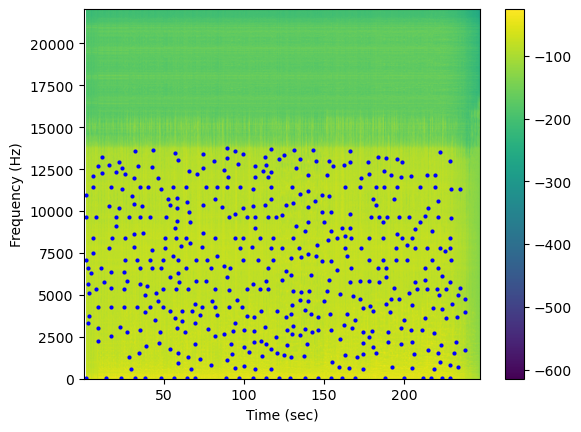

In [21]:
plot_song(aud)

In [21]:
# Enough tempo detection, lets try ECDF
# Luckily I already had code for this too from previous years with a little searching!
# https://rsokl.github.io/CogWeb/Audio/Exercises/PeakFinding.html

def ecdf(data):
    """Returns (x) the sorted data and (y) the empirical cumulative-proportion
    of each datum.

    Parameters
    ----------
    data : numpy.ndarray, size-N

    Returns
    -------
    Tuple[numpy.ndarray shape-(N,), numpy.ndarray shape-(N,)]
        Sorted data, empirical CDF values"""
    data = np.asarray(data).ravel()  # flattens the data
    y = np.linspace(1 / len(data), 1, len(data))  # stores the cumulative proportion associated with each sorted datum
    x = np.sort(data)
    return x, y

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))


ax1.hist(np.log(S).ravel(), bins=100, density=True)
ax1.set_xlabel(r"$\log(|a_{k}|)$")
ax1.set_ylabel(r"Proportion")
ax1.grid()

x, y = ecdf(np.log(S))
ax2.plot(x, y)

ax2.set_xlabel(r"$\log(|a_{k}|)$")
ax2.set_ylabel(r"Cumulative proportion")
ax2.set_title("Cumulative distribution of log-amplitudes")
ax2.grid(True)

In [ ]:
_, cumulative_proportion = ecdf(np.log(S))

In [ ]:
def find_threshold(cumulative_proportion):
    percentiles = {}
    for per in range(1, 11):
        percentiles[per/10] = sum(1 for x in cumulative_proportion if x < per/10 and x > (per - 1)/10)
    return max(percentiles, key=percentiles.get)

In [ ]:
find_threshold(cumulative_proportion)